# A simple engine for image searching: A [SimilaritySearch.jl](https://github.com/sadit/SimilaritySearch.jl) tutorial
## MNIST
by: Eric S. Tellez


## Installing packages
As usual, the first step consists on initializing the environment

In [1]:
using Pkg
pkg"activate ."
# pkg"add Printf MLDatasets LinearAlgebra Images StatsBase StatsPlots https://github.com/sadit/SimilaritySearch.jl"
using Printf, MLDatasets, MLDataUtils, LinearAlgebra, Images, StatsBase, StatsPlots, Statistics, SimilaritySearch


Activating environment at `~/Research/SimilaritySearch.jl/tutorials/Project.toml`


## Loading benchmarks
Here we use the [Fashion-MNIST](https://juliaml.github.io/MLDatasets.jl/latest/datasets/FashionMNIST/) dataset (loaded with MLDatasets) which is designed to be a drop-in replacement for the well known MNIST.

In [2]:
function load_data()
    #train_X, train_y = FashionMNIST.traindata()
    #test_X, test_y = FashionMNIST.testdata()
    
    train_X, train_y = MNIST.traindata()
    test_X, test_y = MNIST.testdata()
    le = labelenc(train_y)
    train_y = label2ind.(train_y, le)
    test_y = label2ind.(test_y, le)
    (train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
end

D = load_data()
size(D.train_X), size(D.test_X), typeof(D.train_X)

((28, 28, 60000), (28, 28, 10000), Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}})

## About preparing the data
While `SimilaritySearch.jl` works with several data types, we decide to convert data instead of writing a new distance function
to handle each image; also, it provides some speedup and reduces overflow problems on direct computation over the `MLDatasets.jl`'s numeric encoding for _MNIST_ and _Fashion-MNIST_.

In [3]:

vec(X, i) = Float32.(reshape(view(X, :, :, i), 28 * 28))
dist = l2_distance

#vec(X, i) = Float32.(reshape(view(X, :, :, i), 28 * 28)) |> normalize!
#dist = angle_distance

X = [vec(D.train_X, i) for i in 1:60000]
queries = [vec(D.test_X, i) for i in 1:10000]
eltype(X)

Array{Float32,1}

## Visualizing
The following functions will display images in the notebook

In [4]:
display_one(m) = display(Gray.(reshape(m, 28, 28))')
display_many(arr) = display(Gray.(hcat([reshape(m, 28, 28)' for m in arr]...)))


display_many (generic function with 1 method)

## Searching demos

The first demo is made with an exhaustive search; this algorithm is pretty simple but low performant; it is indicated whenever the construction time can't be amortized by the number of queries.

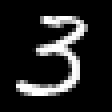

results (obj => dist): 21188 => 4.25, 25646 => 4.34, 9880 => 4.68, 21076 => 4.75, 54030 => 4.88, 19182 => 4.91, 58956 => 4.93, 13880 => 4.95, 9798 => 4.98, 24988 => 5.02, 40740 => 5.03, 9413 => 5.07, 1313 => 5.12, 21100 => 5.13, 58114 => 5.13

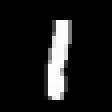

  0.064588 seconds (85.64 k allocations: 4.599 MiB)


results (obj => dist): 34169 => 1.79, 4471 => 1.89, 14222 => 2.06, 8157 => 2.13, 45975 => 2.17, 25245 => 2.30, 40349 => 2.31, 11433 => 2.35, 36298 => 2.35, 29408 => 2.37, 19422 => 2.38, 21282 => 2.51, 19842 => 2.52, 14022 => 2.55, 21830 => 2.55

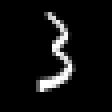

results (obj => dist): 27173 => 4.15, 55759 => 4.42, 25769 => 4.64, 50645 => 4.96, 2287 => 5.01, 13569 => 5.06, 12813 => 5.12, 40481 => 5.14, 57744 => 5.15, 54757 => 5.22, 51389 => 5.22, 1235 => 5.25, 43013 => 5.26, 29603 => 5.30, 20037 => 5.30

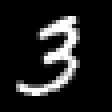

results (obj => dist): 24282 => 4.12, 7044 => 4.33, 8164 => 4.80, 23000 => 4.85, 10138 => 4.98, 39982 => 4.98, 22978 => 5.01, 13194 => 5.02, 3348 => 5.08, 20440 => 5.10, 58334 => 5.11, 3292 => 5.14, 22964 => 5.17, 23528 => 5.21, 32088 => 5.31

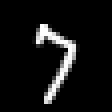

results (obj => dist): 22023 => 3.64, 18430 => 3.69, 43076 => 3.71, 59277 => 3.74, 47062 => 3.99, 18334 => 4.00, 41929 => 4.04, 18470 => 4.05, 55849 => 4.08, 20559 => 4.13, 36555 => 4.13, 1023 => 4.15, 34577 => 4.18, 13043 => 4.20, 52364 => 4.23

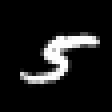

  0.020501 seconds (3 allocations: 368 bytes)
  0.019887 seconds (3 allocations: 368 bytes)
  0.021860 seconds (3 allocations: 368 bytes)
  0.020332 seconds (3 allocations: 368 bytes)


results (obj => dist): 24354 => 3.95, 13238 => 4.02, 41476 => 4.08, 35398 => 4.14, 28680 => 4.25, 33014 => 4.34, 40588 => 4.38, 6452 => 4.51, 35536 => 4.51, 53194 => 4.62, 32218 => 4.62, 24256 => 4.63, 12450 => 4.63, 12270 => 4.65, 55644 => 4.68

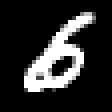

results (obj => dist): 18404 => 5.40, 18526 => 5.41, 30064 => 5.57, 56212 => 5.92, 598 => 6.06, 44316 => 6.06, 34061 => 6.07, 42254 => 6.08, 42144 => 6.10, 30162 => 6.11, 50504 => 6.13, 10856 => 6.15, 6475 => 6.17, 35120 => 6.20, 24238 => 6.22

  0.020034 seconds (3 allocations: 368 bytes)
  0.019853 seconds (3 allocations: 368 bytes)


In [5]:

function sequential_search_demo()
    index = fit(Sequential, X)

    for q in rand(queries, 7)
        display_one(q)
        @time res = search(index, l2_distance, q, KnnResult(15))
        display_many([X[p.objID] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

seq = sequential_search_demo();

## Searching with faster indexes
Fast exact indexes can be created using metric division strategies, but the faster ones some times are designed to retrieve an approximation of the solution. In any case, indexes for fast similarity search need to amortize the construction cost with a large number of queries. The following functions only exemplify the searching process, however, the number of queries is too small to show the typical case of use of these indexes.

## Experiments with a K-Nearest References index (Knr)

The `Knr` is a simple but effective index that allows fast searching in high dimensional datasets.

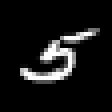

  2.072205 seconds (828.86 k allocations: 46.897 MiB, 1.00% gc time)
 

results (obj => dist): 44148 => 3.82, 1090 => 4.12, 59924 => 4.17, 5310 => 4.35, 35118 => 4.38, 19078 => 4.43, 30126 => 4.43, 23726 => 4.50, 8308 => 4.60, 19036 => 4.68, 41524 => 4.78, 30648 => 4.79, 23568 => 4.79, 22984 => 4.81, 7736 => 4.84

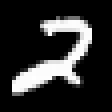

results (obj => dist): 23888 => 5.26, 23778 => 5.31, 55658 => 5.41, 53942 => 5.42, 35510 => 5.49, 44248 => 5.49, 27552 => 5.57, 6446 => 5.58, 47084 => 5.59, 15058 => 5.62, 12130 => 5.63, 25218 => 5.70, 13278 => 5.77, 57616 => 5.79, 49412 => 5.84

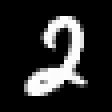

results (obj => dist): 11148 => 3.52, 53863 => 4.91, 11096 => 5.28, 24204 => 5.32, 26032 => 5.39, 44612 => 5.41, 11194 => 5.42, 29742 => 5.47, 9022 => 5.49, 8973 => 5.50, 55090 => 5.60, 29454 => 5.68, 52414 => 5.74, 41985 => 5.75, 27753 => 5.85

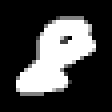

results (obj => dist): 5035 => 5.51, 1874 => 6.53, 41894 => 6.70, 14615 => 6.89, 13078 => 6.99, 1194 => 7.00, 19476 => 7.05, 13082 => 7.06, 37254 => 7.10, 40468 => 7.11, 10234 => 7.16, 23090 => 7.25, 51164 => 7.28, 1208 => 7.30, 28148 => 7.32

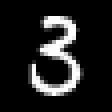

results (obj => dist): 31812 => 4.11, 45089 => 4.18, 49628 => 4.47, 20244 => 4.61, 13143 => 4.63, 54973 => 4.67, 16694 => 4.67, 10901 => 4.68, 1632 => 4.83, 29651 => 4.84, 11342 => 4.86, 43101 => 4.96, 48869 => 5.00, 26556 => 5.02, 50034 => 5.11

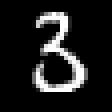

results (obj => dist): 40571 => 4.77, 23203 => 4.87, 36803 => 4.87, 17732 => 5.12, 41086 => 5.28, 24970 => 5.30, 12095 => 5.31, 9005 => 5.36, 48015 => 5.37, 55337 => 5.39, 31776 => 5.53, 31723 => 5.61, 5943 => 5.62, 50008 => 5.75, 18031 => 5.83

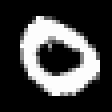

results (obj => dist): 14776 => 5.08, 14730 => 5.49, 41589 => 5.50, 57543 => 5.60, 28109 => 5.86, 32551 => 5.91, 28547 => 6.11, 10129 => 6.13, 14694 => 6.14, 23278 => 6.14, 31139 => 6.27, 49519 => 6.31, 14718 => 6.31, 14676 => 6.33, 14774 => 6.37

 0.034364 seconds (24.27 k allocations: 1.314 MiB)
  0.001782 seconds (9 allocations: 117.828 KiB)
  0.002592 seconds (9 allocations: 117.828 KiB)
  0.001147 seconds (9 allocations: 117.828 KiB)
  0.004712 seconds (9 allocations: 117.828 KiB)
  0.003419 seconds (9 allocations: 117.828 KiB)
  0.001772 seconds (9 allocations: 117.828 KiB)


In [6]:
function knr_search_demo()
    @time index = fit(Knr, l2_distance, X, numrefs=128, verbose=false)
    # we can optimize the index to achieve a desired quality (trading with search time)
    optimize!(index, dist, recall=0.95)
    
    for q in rand(queries, 7)
        display_one(q)
        @time res = search(index, l2_distance, q, KnnResult(15))
        display_many([X[p.objID] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

knr = knr_search_demo();

## Solving queries with a proximity search graph
The `SearchGraph` is a faster index but with a more expensive construction.

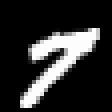

 21.360685 seconds (21.45 M allocations: 2.233 GiB, 2.82% gc time)
 

results (obj => dist): 49492 => 4.04, 49552 => 4.87, 22942 => 4.97, 33154 => 5.16, 49532 => 5.32, 22872 => 5.54, 35122 => 5.55, 41368 => 5.57, 34882 => 5.62, 59989 => 5.65, 32174 => 5.66, 32198 => 5.71, 12414 => 5.72, 40466 => 5.76, 20910 => 5.78

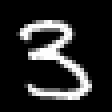

results (obj => dist): 35807 => 5.24, 9521 => 5.39, 58066 => 5.60, 57265 => 5.60, 3405 => 5.65, 5959 => 5.80, 47685 => 6.07, 50604 => 6.08, 46307 => 6.15, 50694 => 6.22, 54953 => 6.24, 55051 => 6.28, 16557 => 6.31, 50684 => 6.32, 7413 => 6.33

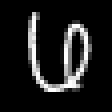

results (obj => dist): 31861 => 7.49, 36973 => 7.51, 41167 => 7.60, 32173 => 7.61, 7125 => 7.64, 37617 => 7.66, 49723 => 7.67, 13857 => 7.70, 52147 => 7.72, 1577 => 7.74, 53613 => 7.74, 47212 => 7.76, 17971 => 7.81, 57906 => 7.82, 22139 => 7.83

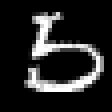

results (obj => dist): 43207 => 6.76, 21773 => 7.19, 46189 => 7.40, 11271 => 7.54, 46879 => 7.54, 39779 => 7.57, 21559 => 7.57, 45283 => 7.62, 8315 => 7.69, 16117 => 7.70, 27778 => 7.75, 13897 => 7.79, 36009 => 7.82, 40613 => 7.89, 15875 => 7.92

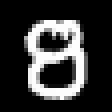

results (obj => dist): 54057 => 5.69, 32775 => 6.18, 21376 => 6.44, 47670 => 6.52, 43009 => 6.53, 29605 => 6.57, 13743 => 6.61, 57325 => 6.69, 3743 => 6.86, 7983 => 6.86, 45294 => 6.92, 55257 => 6.95, 23392 => 7.02, 7289 => 7.04, 50903 => 7.07

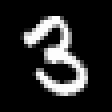

results (obj => dist): 33819 => 5.31, 32812 => 5.64, 26662 => 5.77, 34541 => 5.93, 34789 => 5.95, 12015 => 5.96, 33147 => 5.98, 58925 => 5.99, 41609 => 6.06, 58854 => 6.07, 27671 => 6.09, 7045 => 6.14, 51935 => 6.16, 44835 => 6.17, 36193 => 6.27

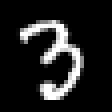

results (obj => dist): 48393 => 4.93, 15478 => 4.97, 15969 => 5.10, 34236 => 5.11, 48795 => 5.13, 14003 => 5.13, 16292 => 5.27, 56625 => 5.27, 48326 => 5.33, 21571 => 5.44, 36593 => 5.62, 48292 => 5.64, 18045 => 5.69, 30001 => 5.70, 8569 => 5.74

 0.000308 seconds (20 allocations: 19.578 KiB)
  0.000527 seconds (20 allocations: 19.578 KiB)
  0.000613 seconds (20 allocations: 19.578 KiB)
  0.000428 seconds (20 allocations: 19.578 KiB)
  0.000659 seconds (20 allocations: 19.578 KiB)
  0.000237 seconds (20 allocations: 19.578 KiB)
  0.000327 seconds (20 allocations: 19.578 KiB)


In [7]:
function searchgraph_search_demo()
    # a real index only works whenever the number of queries amortizes the construction cost
    @time index = fit(SearchGraph, l2_distance, X, verbose=false)
    optimize!(index, l2_distance, recall=0.95)
    for q in rand(queries, 7)
        display_one(q)
        @time res = search(index, l2_distance, q, KnnResult(15))
        display_many([X[p.objID] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

sgraph = searchgraph_search_demo();

## A simple KNN classifier
Lets create a classifier to measure the performance and the quality impact of the different indexes

In [8]:
function classify(index, train_y, queries, test_y, k=1)
    ypred = []
    for i in eachindex(queries)
        res = search(index, l2_distance, queries[i], KnnResult(k))
        if k == 1
            push!(ypred, train_y[first(res).objID])
        else
            labels = train_y[[p.objID for p in res]]
            c = counts(labels, 1:10)
            push!(ypred, findmax(c)[end])
        end
    end
    
    println("$(k)NN-classifier $(typeof(index)) accuracy:", mean(ypred .== test_y))
end


classify (generic function with 2 methods)

In [9]:
@time classify(seq, D.train_y, queries, D.test_y)
@time classify(knr, D.train_y, queries, D.test_y)
@time classify(sgraph, D.train_y, queries, D.test_y)

1NN-classifier Sequential{Array{Float32,1}} accuracy:0.9691
195.389156 seconds (674.75 k allocations: 34.478 MiB, 0.01% gc time)
1NN-classifier Knr{Array{Float32,1}} accuracy:0.9669
 38.255287 seconds (192.03 k allocations: 1.127 GiB, 0.61% gc time)
1NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.9612
  3.071176 seconds (304.42 k allocations: 223.741 MiB, 1.10% gc time)


In [10]:
for k in [1, 5, 9, 13, 17]
    @time classify(sgraph, D.train_y, queries, D.test_y, k)
end

1NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.961
  3.775188 seconds (212.18 k allocations: 222.987 MiB, 1.10% gc time)
5NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.9592
  3.353334 seconds (262.35 k allocations: 227.919 MiB, 0.94% gc time)
9NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.9551
  3.171535 seconds (262.34 k allocations: 229.013 MiB, 0.89% gc time)
13NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.9544
  3.286280 seconds (262.36 k allocations: 230.361 MiB, 0.80% gc time)
17NN-classifier SearchGraph{Array{Float32,1}} accuracy:0.9509
  3.836177 seconds (283.47 k allocations: 315.837 MiB, 1.14% gc time)
